In [1]:
import scipy as sc
import numpy as np
import pandas as pd
import itertools
from scipy import stats
import scipy

from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

* LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
* SEX: пол клиента (1 = мужской, 2 = женский )
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
* AGE: возраст в годах
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
* default - индикатор невозврата денежных средств

In [2]:
data = pd.read_csv("credit_card_default_analysis.csv", sep=",") 
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
len(data)

30000

## Задание 1

Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [109]:
data_return = data[data['default'] == 0]
data_not_return = data[data['default'] == 1]
print len(data_return)
print len(data_not_return)

23364
6636


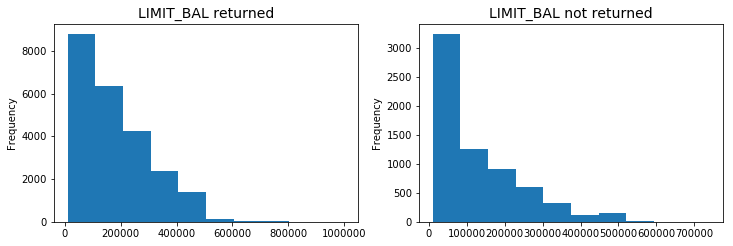

In [5]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
data_return['LIMIT_BAL'].plot.hist()
pylab.title('LIMIT_BAL returned', fontsize=14)
pylab.subplot(2,2,2)
data_not_return['LIMIT_BAL'].plot.hist()
pylab.title('LIMIT_BAL not returned', fontsize=14)
pylab.show()

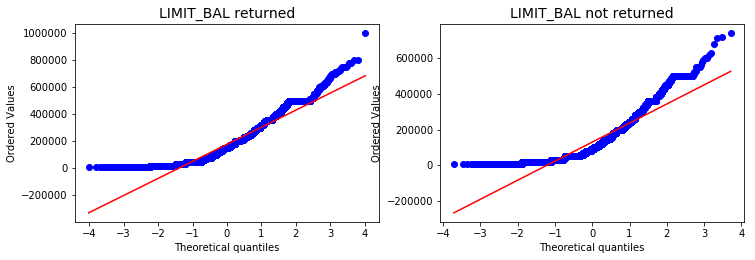

In [6]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(data_return['LIMIT_BAL'], dist="norm", plot=pylab)
pylab.title('LIMIT_BAL returned', fontsize=14)
pylab.subplot(2,2,2)
stats.probplot(data_not_return['LIMIT_BAL'], dist="norm", plot=pylab)
pylab.title('LIMIT_BAL not returned', fontsize=14)
pylab.show()

Похоже, данные распределены не нормально. Параметрические критерии применять нельзя.

Критерий Манна-Уитни нельзя использовать из-за его ограничений на кол-во повторяющихся значений в выборке.

### a) Построим доверительные интервалы для медиан

In [111]:
def get_median_confint(rank_list):
    n = len(rank_list)
    k = int(np.round(0.5 * (n - 1.96 * np.sqrt(n) - 1)))
    l = k - 1
    u = n - k 
    return (rank_list[l], rank_list[u])

In [59]:
rank_list_return = data_return.sort_values(['LIMIT_BAL'])['LIMIT_BAL']
rank_list_not_return = data_not_return.sort_values(['LIMIT_BAL'])['LIMIT_BAL']
print '95%% доверительный интервал медианы кредитного лимита для вернувших кредит: [%f, %f]' % get_median_confint(rank_list_return.tolist())
print '95%% доверительный интервал медианы кредитного лимита для не вернувших кредит: [%f, %f]' % get_median_confint(rank_list_not_return.tolist())

95% доверительный интервал медианы кредитного лимита для вернувших кредит: [150000.000000, 150000.000000]
95% доверительный интервал медианы кредитного лимита для не вернувших кредит: [80000.000000, 90000.000000]


Интервалы не пересекаются - кредитные лимиты разные.

### b)

Проверим равенство распределений кредитного лимита с помощью перестановочного критерия для независимых выборок.

H0: распределения равны

H1: распределения не равны

In [115]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [15]:
print "p-value: %f" % permutation_test(data_return['LIMIT_BAL'], data_not_return['LIMIT_BAL'], max_permutations = 10000)

p-value: 0.000100


Достигаемый уровень значимости очень меленький, нулевую гипотезу можно с уверенностью отвергнуть на уровне значимости 0.95.

## Задание 2

Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [74]:
data_man = data[data['SEX'] == 1]
data_woman = data[data['SEX'] == 2]
print len(data_man)
print len(data_woman)

11888
18112


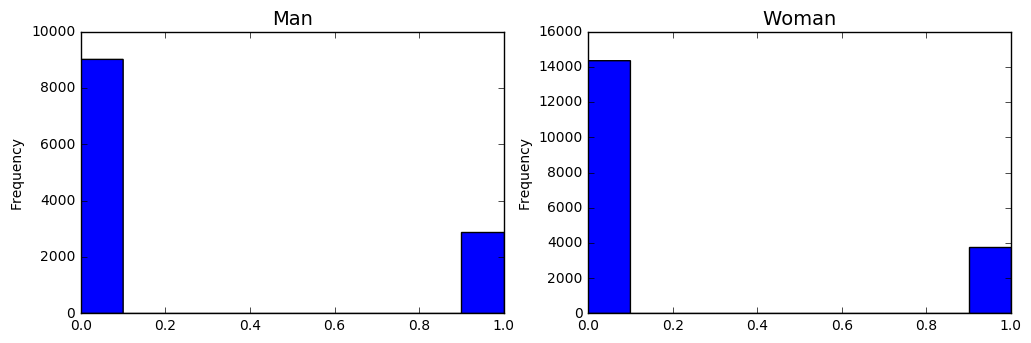

In [85]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
data_man['default'].plot.hist()
pylab.title('Man', fontsize=14)
pylab.subplot(2,2,2)
data_woman['default'].plot.hist()
pylab.title('Woman', fontsize=14)
pylab.show()

По графикам не видно ощутимой разницы между долями не вернувших кредит среди мужчин и женщин.

In [10]:
conf_interval_man = proportion_confint(sum(data_man['default']), 
                                            len(data_man),
                                            method = 'wilson')
conf_interval_woman = proportion_confint(sum(data_woman['default']), 
                                            len(data_woman),
                                            method = 'wilson')

print '95%% доверительный интервал вероятности, что мужчина не вернет кредит: [%f, %f]' % conf_interval_man
print '95%% доверительный интервал вероятности, что женщина не вернет кредит: [%f, %f]' % conf_interval_woman

95% доверительный интервал вероятности, что мужчина не вернет кредит: [0.234061, 0.249450]
95% доверительный интервал вероятности, что женщина не вернет кредит: [0.201917, 0.213733]


Интервалы не пересекаются. Похоже, что мужчины чаще не возвращают кредиты

In [11]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [12]:
print "95%% доверительный интервал разницы двух долей: [%f, %f]" %\
      proportions_diff_confint_ind(data_man['default'], data_woman['default'])

95% доверительный интервал разницы двух долей: [0.024207, 0.043612]


В доверительный интервал разницы двух долей не входит ноль и интервал правее нуля. Это еще одно подтверждение, что мужчины чаще не возвращают кредит.

Проверим гипотизу:

H0: мужчины не возращают кредит с такой же вероятностью, что и женщины

H1: вероятности отличаются (двусторонняя алтернатива)

In [13]:
p = proportions_diff_z_test(proportions_diff_z_stat_ind(data_man['default'], data_woman['default']))
p

4.4728665216098307e-12

Нулевая гипотеза уверенно отвергается.

## Задание 3

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).

In [28]:
educ_dict = {'doctor':0,'magistr':1,'bakalavr':2,'vipusknik':3,'nachalnoe':4,'over':5}
index = ['return', 'not return']
data3 = pd.DataFrame(columns=educ_dict.keys(), index=index)

for educ in educ_dict.keys():
    d = data[data['EDUCATION'] == educ_dict[educ]]['default']
    data3[educ] = [len(d)-sum(d), sum(d)]
    
data3

,magistr,vipusknik,bakalavr,doctor,over,nachalnoe
return,8549,3680,10700,14,262,116
not return,2036,1237,3330,0,18,7


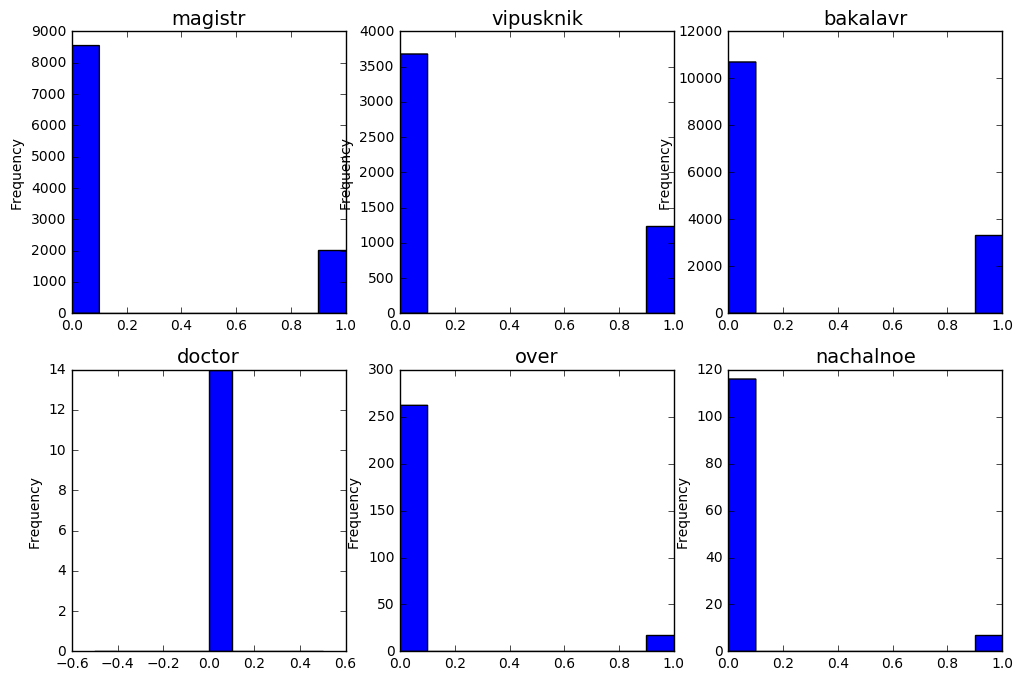

In [92]:
pylab.figure(figsize=(12,8))

index = 1
for educ in educ_dict.keys():
    d = data[data['EDUCATION'] == educ_dict[educ]]['default']
    pylab.subplot(2,3,index)
    pylab.title('Married', fontsize=14)
    d.plot.hist()
    pylab.title(educ, fontsize=14)
    index = index + 1
    
pylab.show()

С помощью критерия хи-квадрат проверим гипотизу H0 о том, что образование не влияет на то, вернет ли человек долг, против двусторонней алтернативы. 

In [44]:
chi2 = stats.chi2_contingency(data3.as_matrix())
print 'Достигаемый уровень значимости p = %s' % chi2[1]

Достигаемый уровень значимости p = 3.83555441089e-33


Нулевую гипотезу можно с уверенностью отвергнуть. Образование определенно влияет на возврат долга.

Составим таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. 

In [73]:
data3_2 = pd.DataFrame(columns=educ_dict.keys())
data3_2.loc['Вернули (наблюдаемое)'] = data3.loc['return']
data3_2.loc['Вернули (ожидаемое)'] = np.round(chi2[3][1])
data3_2.loc['Наблюдаемое - ожидаемое'] = data3_2.iloc[0] - data3_2.iloc[1] 
data3_2.loc['Всего людей такой профессии'] = [0,0,0,0,0,0]

for educ in educ_dict.keys():
    d = data[data['EDUCATION'] == educ_dict[educ]]['default']
    data3_2[educ]['Всего людей такой профессии'] = len(d)
    
#data3_2.loc['Доля набл.'] = np.round(data3_2.iloc[0] / data3_2.iloc[3], 2)
#data3_2.loc['Доля ож.'] = np.round(data3_2.iloc[1] / data3_2.iloc[3], 2)
    
data3_2.loc['Разница в долях'] = np.round((data3_2.iloc[0] / data3_2.iloc[3]) - (data3_2.iloc[1] / data3_2.iloc[3]), 2)

data3_2

,magistr,vipusknik,bakalavr,doctor,over,nachalnoe
Вернули (наблюдаемое),8549.00,3680.00,10700.00,14.00,262.00,116.00
Вернули (ожидаемое),2343.00,1088.00,3105.00,3.00,62.00,27.00
Наблюдаемое - ожидаемое,6206.00,2592.00,7595.00,11.00,200.00,89.00
Всего людей такой профессии,10585.00,4917.00,14030.00,14.00,280.00,123.00
Разница в долях,0.59,0.53,0.54,0.79,0.71,0.72


В последнем столбце приведена разница между наблюдаемым и ожидаемым долями вернувших долг. Похоже, что чаще других отдают долг врачи. Реже других - выпускники школы.

## Задание 4

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

Посмотрим на данные.
MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).

In [87]:
data_marr = data[data['MARRIAGE'] == 1]
data_not_marr = data[data['MARRIAGE'] == 2]
print len(data_marr)
print len(data_not_marr)

13659
15964


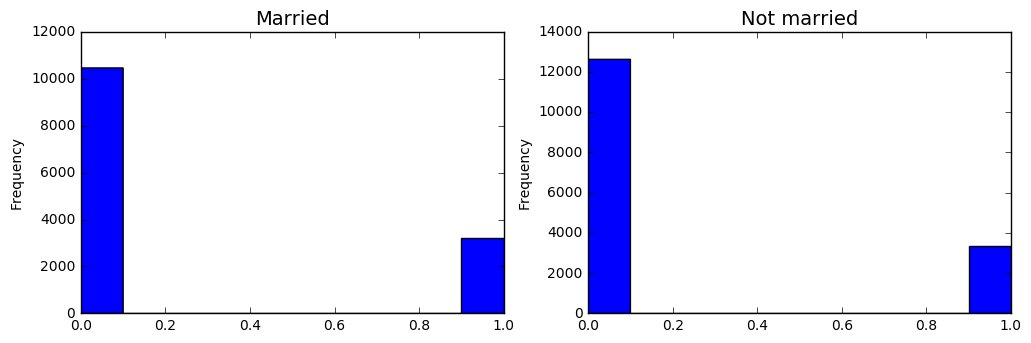

In [88]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
data_marr['default'].plot.hist()
pylab.title('Married', fontsize=14)
pylab.subplot(2,2,2)
data_not_marr['default'].plot.hist()
pylab.title('Not married', fontsize=14)
pylab.show()

По графикам не видно ощутимой разницы между долями не вернувших кредит среди женатых и холостых.

Связь семейного статуса с индикатором дефолта можно проверить с помощью коэффициента корреляции Мэтьюса. 

In [96]:
married = ['married', 'not married']
index = ['return', 'not return']
data4 = pd.DataFrame(columns=married, index=index)
data4['married']['not return'] = sum(data_marr['default'])
data4['not married']['not return'] = sum(data_not_marr['default'])
data4['married']['return'] = len(data_marr['default']) - sum(data_marr['default'])
data4['not married']['return'] = len(data_not_marr['default']) - sum(data_not_marr['default'])

data4

,married,not married
return,10453,12623
not return,3206,3341


In [98]:
a = data4['married']['return']
b = data4['not married']['return']
c = data4['married']['not return']
d = data4['not married']['not return']

In [101]:
mcc = (a*d - b*c) / np.sqrt((a+b)*(a+c)*(b+d)*(c+d))
print 'Коэффициента корреляции Мэтьюса %s' % np.round(mcc, 4)

Коэффициента корреляции Мэтьюса -0.0306


Отрицательный коэфф. кореляции указывает на то, что люди в браке реже возвращают кредит.

In [105]:
print a / float(a + c)
print b / float(b + d)

0.765282963614
0.790716612378


Проверим, значимо ли значение коэффициента мэтьюса. С помощью критерия хи-квадрат проверим гипотизу H0 о том, что замужество не влияет на то, вернет ли человек долг, против двусторонней алтернативы.

In [103]:
chi2_5 = stats.chi2_contingency(np.array([[a, b],[c, d]]))
print 'Достикаемый уровень значимости: %s' % chi2_5[1]

Достикаемый уровень значимости: 1.5633210356e-07


Нулевую гипотезу можно с уверенностью отвергунть на уровне значимости 0.95. Холостые люди чаще отдают кредит.

## Задание 5

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения?

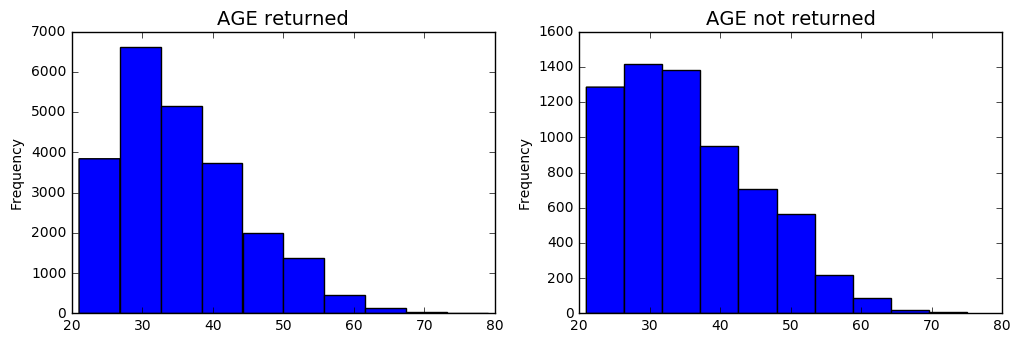

In [106]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
data_return['AGE'].plot.hist()
pylab.title('AGE returned', fontsize=14)
pylab.subplot(2,2,2)
data_not_return['AGE'].plot.hist()
pylab.title('AGE not returned', fontsize=14)
pylab.show()

Похоже, среди вернувших меньше доля 20-ти летних.

In [112]:
rank_list_return = data_return.sort_values(['AGE'])['AGE']
rank_list_not_return = data_not_return.sort_values(['AGE'])['AGE']
print '95%% доверительный интервал медианы возраста для вернувших кредит: [%f, %f]' % get_median_confint(rank_list_return.tolist())
print '95%% доверительный интервал медианы возраста для не вернувших кредит: [%f, %f]' % get_median_confint(rank_list_not_return.tolist())

95% доверительный интервал медианы кредитного лимита для вернувших кредит: [34.000000, 34.000000]
95% доверительный интервал медианы кредитного лимита для не вернувших кредит: [34.000000, 35.000000]


Интервалы пересекаются, по ним нельзя утверждать, что медианы возраста в группах различаются.

Проверим равенство распределений возраста с помощью перестановочного критерия для независимых выборок.
H0: распределения равны
H1: распределения не равны

In [116]:
print "p-value: %f" % permutation_test(data_return['AGE'], data_not_return['AGE'], max_permutations = 10000)

p-value: 0.017200


Нулевую гипотезу можно с отвергнуть на уровне значимости 0.95.